In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(torch.__version__)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.4.0
cuda


In [26]:
from torchvision import datasets,transforms
mnist_train=datasets.MNIST(root='./data/',train=True, transform=transforms.ToTensor(),download=True)
mnist_test=datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print('done')

done


^C


In [27]:
batch=256
train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch,shuffle=True,num_workers=1)
test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch,shuffle=True,num_workers=1)
print('done')

done


In [28]:
class MLP(nn.Module):
    def __init__ (self, name='mlp',xdim=784,hdim=256,ydim=10):
        super(MLP,self).__init__()
        self.name=name
        self.xdim=xdim
        self.hdim=hdim
        self.ydim=ydim
        self.lin_1=nn.Linear(self.xdim,self.hdim)
        self.lin_2=nn.Linear(self.hdim,self.xdim)
        self.init_param() # initialize parameters
    
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)
    def forward(self, x):
        net=x
        net=self.lin_1(x)
        net=F.relu(net)
        net=self.lin_2(net)
        return net

M=MLP(name='mlp' ,xdim=784,hdim=356,ydim=10).to(device)
loss=nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(),lr=1e-3)
print('done')

                      
        

done


In [29]:
x_numpy = np.random.rand(2,784)
x_torch=torch.from_numpy(x_numpy).float().to(device)
y_torch=M.forward(x_torch) #forward path
y_numpy=y_torch.detach().cpu().numpy() # torch tensor to numpy array
print(x_numpy)
print(x_torch)
print(y_numpy)
print(y_torch)

[[0.413 0.774 0.638 ... 0.079 0.292 0.128]
 [0.281 0.134 0.816 ... 0.218 0.72  0.516]]
tensor([[0.4128, 0.7740, 0.6381,  ..., 0.0785, 0.2918, 0.1278],
        [0.2807, 0.1338, 0.8164,  ..., 0.2179, 0.7195, 0.5157]],
       device='cuda:0')
[[-1.002  0.923 -0.704 ...  0.177  0.272  0.556]
 [-1.489  0.053 -0.945 ...  0.198 -0.754  1.398]]
tensor([[-1.0021,  0.9235, -0.7039,  ...,  0.1775,  0.2723,  0.5560],
        [-1.4892,  0.0527, -0.9452,  ...,  0.1977, -0.7541,  1.3978]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [30]:
#check parameters
np.set_printoptions(precision=3)
n_param=0
for idx,(param_name,param) in enumerate(M.named_parameters()):
    param_numpy=param.detach().cpu().numpy()
    n_param+=len(param_numpy.reshape(-1))
    print(f'{idx} name: {param_name} shape: {param_numpy.shape}')
    print(f'value:{param_numpy.reshape(-1)[:5]}')
print(f'total number fo parameters:{n_param}')

0 name: lin_1.weight shape: (356, 784)
value:[ 0.057 -0.059 -0.085 -0.034 -0.047]
1 name: lin_1.bias shape: (356,)
value:[0. 0. 0. 0. 0.]
2 name: lin_2.weight shape: (784, 356)
value:[-0.012  0.024 -0.188 -0.039  0.034]
3 name: lin_2.bias shape: (784,)
value:[0. 0. 0. 0. 0.]
total number fo parameters:559348


In [31]:
# evalution function 평가를 해야겟지

def func_eval(model,data_iter,device):
    with torch.no_grad():
        model.eval()# evaluate (affects DropOut and BN)
        n_total, n_correct =0,0
        for batch_in, batch_out in data_iter:
            y_trgt= batch_out.to(device)
            model_pred=model(batch_in.view(-1,28*28).to(device))
            _,y_pred =torch.max(model_pred.data,1)
            n_correct+=(y_pred==y_trgt).sum().item()
            n_total+=batch_in.size(0)
        val_accr=(n_correct/n_total)
        model.train()# back to train mode 
    return val_accr
print('done')


done


In [32]:
M.init_param() #  파라미터 값 초기화
train_accr=func_eval(M,train_iter,device)
test_accr=func_eval(M,test_iter,device)
print(f'train_accr:{train_accr}')
print(f'test_accr:{test_accr}')

train_accr:0.0005333333333333334
test_accr:0.0007


In [35]:
%%time
print('training start')

M.init_param()
M.train()
epochs,print_e=10,1
for epoch in range(epochs):
    loss_val_sum=0
    for batch_in, batch_out in train_iter:
        y_pred =M.forward(batch_in.view(-1,28*28).to(device))
        loss_out=loss(y_pred,batch_out.to(device))
        optm.zero_grad()# reset gradient
        loss_out.backward()# backpropagate
        optm.step() # 옵티마이저 업데이트
        loss_val_sum+=loss_out
    loss_val_avg=loss_val_sum/len(train_iter)
    #print
    if((epoch%print_e)==0) or (epoch==(epochs-1)):
        train_accr=func_eval(M,train_iter,device)
        test_accr=func_eval(M,test_iter,device)
        print(f'epoch:{epoch} lostt: {loss_val_avg} train_accr:{train_accr} test_accr:{test_accr}')
print('done')


training start
epoch:0 lostt: 0.3897113800048828 train_accr:0.9500166666666666 test_accr:0.9465
epoch:1 lostt: 0.15566712617874146 train_accr:0.9654166666666667 test_accr:0.9627
epoch:2 lostt: 0.11070344597101212 train_accr:0.9758333333333333 test_accr:0.9687
epoch:3 lostt: 0.08539155125617981 train_accr:0.9788833333333333 test_accr:0.9704
epoch:4 lostt: 0.06897367537021637 train_accr:0.9850166666666667 test_accr:0.9751
epoch:5 lostt: 0.056869395077228546 train_accr:0.9851333333333333 test_accr:0.9747
epoch:6 lostt: 0.047348231077194214 train_accr:0.9904166666666666 test_accr:0.9787
epoch:7 lostt: 0.03935708850622177 train_accr:0.9915833333333334 test_accr:0.9776
epoch:8 lostt: 0.032801248133182526 train_accr:0.9938333333333333 test_accr:0.9772
epoch:9 lostt: 0.028438128530979156 train_accr:0.9949666666666667 test_accr:0.9795
done
Wall time: 1min 55s


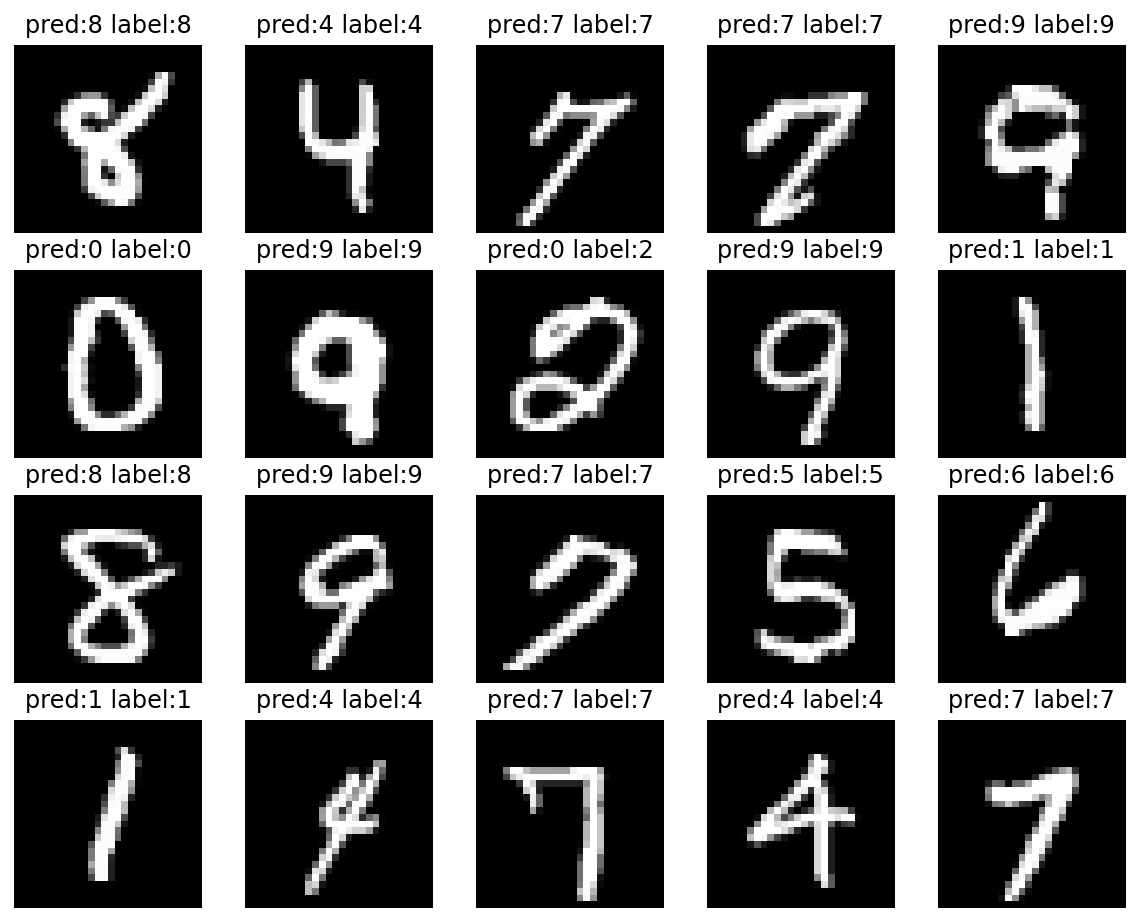

done


In [36]:
n_sample=20
sample_indices=np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x=mnist_test.data[sample_indices]
test_y=mnist_test.targets[sample_indices]
with torch.no_grad():
    y_pred=M.forward(test_x.view(-1,28*28).type(torch.float).to(device)/255)
y_pred=y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5,5,idx+1)
    plt.imshow(test_x[idx],cmap='gray')
    plt.axis('off')
    plt.title(f'pred:{y_pred[idx]} label:{test_y[idx]}')
plt.show()
print('done')